In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import ast
import os

In [7]:
DATA_DIR = './Experiment-Data/'
SC_DIR = os.path.join(DATA_DIR, 'Self-Controlled')
NSC_DIR = os.path.join(DATA_DIR, 'Non-Self-Controlled')
TEST_DIR = os.path.join(DATA_DIR, 'Test')
TASTE_MAP = {""}
HEALTH_MAP = {""}
# TEST_STORED = False

In [8]:
# def safe_eval(val):
#     """Safely evaluate a string to a Python object, handling 'NaN'."""
#     try:
#         # Replace 'NaN' with a valid placeholder before evaluation
#         val = val.replace('"NaN"', 'null')  # Replace 'NaN' with JSON-compatible 'null'
#         return ast.literal_eval(val)
#     except Exception as e:
#         print(f"Failed to evaluate: {val}. Error: {e}")
#         return None
    
def clean_data(df):
    # df = df.dropna()
    df = df[["stim_duration","exp_stage","stim","coded_response","trial_num","reference","stim_rating","reference_rating"]]
    # df["stim_rating"] = df["stim_rating"].apply(safe_eval)
    return df

def flip_coin():
    # 1 -> Move to Yes
    # 0 -> Move to No
    return np.random.choice([0,1])

def satisfies_condition_1(df):
    df = clean_data(df)
    # Iterate over each row
    total = 0
    decline_liked_unhealthy = 0
    choose_disliked_healthy = 0

    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            # print(stim_rating, type(stim_rating))
            if (stim_rating["taste"] == "NaN" or stim_rating["health"] == "NaN" or row["coded_response"] == "NaN"):
                continue

            total += 1
            if int(row["coded_response"]) == 0:
                if flip_coin() == 1:
                    # subject chose it
                    if int(stim_rating["taste"]) == 0:
                        if flip_coin() == 0:
                            # subject disliked it
                            if int(stim_rating["health"]) == 0:
                                if flip_coin() == 1:
                                    # subject found it healthy
                                    choose_disliked_healthy += 1
                            elif int(stim_rating["health"]) > 0:
                                # subject found it healthy
                                choose_disliked_healthy += 1
                    elif int(stim_rating["taste"]) < 0:
                        # subject disliked it
                        if int(stim_rating["health"]) == 0:
                            if flip_coin() == 1:
                                # subject found it healthy
                                choose_disliked_healthy += 1
                        elif int(stim_rating["health"]) > 0:
                            # subject found it healthy
                            choose_disliked_healthy += 1
                else:
                    # subject declined
                    if int(stim_rating["taste"]) == 0:
                        if flip_coin() == 1:
                            # subject liked it
                            if int(stim_rating["health"]) == 0:
                                if flip_coin() == 0:
                                    # subject found it unhealthy
                                    decline_liked_unhealthy += 1
                            elif int(stim_rating["health"]) < 0:
                                # subject found it unhealthy
                                decline_liked_unhealthy += 1
                    elif int(stim_rating["taste"]) > 0:
                        # subject liked it
                        if int(stim_rating["health"]) == 0:
                            if flip_coin() == 0:
                                # subject found it unhealthy
                                decline_liked_unhealthy += 1
                        elif int(stim_rating["health"]) < 0:
                            # subject found it unhealthy
                            decline_liked_unhealthy += 1
            elif int(row["coded_response"]) > 0:
                # subject chose it
                if int(stim_rating["taste"]) == 0:
                    if flip_coin() == 0:
                        # subject disliked it
                        if int(stim_rating["health"]) == 0:
                            if flip_coin() == 1:
                                # subject found it healthy
                                choose_disliked_healthy += 1
                        elif int(stim_rating["health"]) > 0:
                            # subject found it healthy
                            choose_disliked_healthy += 1
                elif int(stim_rating["taste"]) < 0:
                    # subject disliked it
                    if int(stim_rating["health"]) == 0:
                        if flip_coin() == 1:
                            # subject found it healthy
                            choose_disliked_healthy += 1
                    elif int(stim_rating["health"]) > 0:
                        # subject found it healthy
                        choose_disliked_healthy += 1
                    
            else:
                # subject declined it
                if int(stim_rating["taste"]) == 0:
                    if flip_coin() == 1:
                        # subject liked it
                        if int(stim_rating["health"]) == 0:
                            if flip_coin() == 0:
                                # subject found it unhealthy
                                decline_liked_unhealthy += 1
                        elif int(stim_rating["health"]) < 0:
                            # subject found it unhealthy
                            decline_liked_unhealthy += 1
                elif int(stim_rating["taste"]) > 0:
                    # subject liked it
                    if int(stim_rating["health"]) == 0:
                        if flip_coin() == 0:
                            # subject found it unhealthy
                            decline_liked_unhealthy += 1
                    elif int(stim_rating["health"]) < 0:
                        # subject found it unhealthy
                        decline_liked_unhealthy += 1
        else:
            continue
    if ((decline_liked_unhealthy + choose_disliked_healthy) / total) > 0.5:
        return True
    return False

def satisfies_condition_2(df):
    df = clean_data(df)
    # treating Neutral as 0 only. No coin flipping 
    # perform linear regression model of decision strength on the health and taste ratings
    # data_df = pd.DataFrame()
    rows = []
    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            if (stim_rating["taste"] == "NaN" or stim_rating["health"] == "NaN" or row["coded_response"] == "NaN"):
                continue
            rows.append({"taste": stim_rating["taste"], "health": stim_rating["health"], "decision_strength": row["coded_response"]})
            # data_df = data_df.append({"taste": stim_rating["taste"], "health": stim_rating["health"], "decision_strength": row["coded_response"]}, ignore_index=True)
        else:
            continue
    data_df = pd.DataFrame(rows)
    # taste and health are ordinal variables that take values -2, -1, 0, 1, 2 but treated as continuous
    # treating decision strength is a continuous variable that takes values from 0 to 2
    # save the data frame to csv to verify with JASP
    if not(os.path.exists(os.path.join(TEST_DIR,"test.csv"))):
        data_df.to_csv(os.path.join(TEST_DIR,"test.csv"), index=False)
    
    # linear regression model
    # Treat ordinal variables as continuous
    X = data_df[["taste", "health"]]
    y = data_df["decision_strength"]
    
    # Scale the features for better interpretation
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Extract coefficients
    coeff_taste = model.coef_[0]
    coeff_health = model.coef_[1]
    # coeff_health = model_logistic.coef_[1]

    # Output the results
    print(f"Coefficient for taste: {coeff_taste}")
    print(f"Coefficient for health: {coeff_health}")

    if coeff_health > coeff_taste:
        # print("Coefficient of health is greater than coefficient of taste.")
        return True

    # print("Coefficient of taste is greater than or equal to coefficient of health.")
    return False

def satisfies_condition_2_logistic(df):
    df = clean_data(df)
    rows = []
    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            if (
                stim_rating["taste"] == "NaN" or 
                stim_rating["health"] == "NaN" or 
                row["coded_response"] == "NaN"
            ):
                continue
            rows.append({
                "taste": stim_rating["taste"], 
                "health": stim_rating["health"], 
                "decision_strength": abs(row["coded_response"])
            })
    data_df = pd.DataFrame(rows)

    # Save the data frame to CSV for verification
    if not os.path.exists(os.path.join(TEST_DIR, "test.csv")):
        data_df.to_csv(os.path.join(TEST_DIR, "test.csv"), index=False)

    # Features and target
    X = data_df[["taste", "health"]]
    y = data_df["decision_strength"]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit a logistic regression model (multiclass)
    logistic_model = LogisticRegression(multi_class="multinomial", solver="lbfgs")
    logistic_model.fit(X_scaled, y)

    # Extract coefficients for logistic regression
    coeff_matrix = logistic_model.coef_  # Shape (n_classes, n_features)
    coeff_taste = coeff_matrix[:, 0].mean()  
    coeff_health = coeff_matrix[:, 1].mean()  

    # Output the results
    print(f"Average Coefficient for taste: {coeff_taste}")
    print(f"Average Coefficient for health: {coeff_health}")

    return coeff_health > coeff_taste


def satisfies_condition_3_logistic(df):
    df = clean_data(df)
    # data_df = pd.DataFrame()
    rows = []
    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            if (stim_rating["taste"] == "NaN" or stim_rating["health"] == "NaN" or row["coded_response"] == "NaN"):
                continue
            rows.append({"taste": stim_rating["taste"], "health": stim_rating["health"], "decision_strength": abs(row["coded_response"])})
            # data_df = data_df.append({"taste": stim_rating["taste"], "health": stim_rating["health"], "decision_strength": row["coded_response"]}, ignore_index=True)
        else:
            continue
    data_df = pd.DataFrame(rows)
    X_taste = data_df[["taste"]]
    y = data_df["decision_strength"]
    
    # Scale the features for better interpretation
    scaler = StandardScaler()
    X_taste_scaled = scaler.fit_transform(X_taste)

    # Fit the linear regression model
    logistic_model_taste = LogisticRegression(multi_class="multinomial", solver="lbfgs")
    logistic_model_taste.fit(X_taste_scaled, y)

    y_pred_taste = logistic_model_taste.predict(X_taste_scaled)
    r2_taste = r2_score(y, y_pred_taste)

    X_health = data_df[["health"]]
    X_health_scaled = scaler.fit_transform(X_health)
    logistic_model_health = LogisticRegression(multi_class="multinomial", solver="lbfgs")
    logistic_model_health.fit(X_health_scaled, y)
    y_pred_health = logistic_model_health.predict(X_health_scaled)
    r2_health = r2_score(y, y_pred_health)
    
    print(f"R^2 for taste model: {r2_taste}")
    print(f"R^2 for health model: {r2_health}")

    if r2_health > r2_taste:
        # print("R^2 of health model is greater than R^2 of taste model.")
        return True
    # print("R^2 of taste model is greater than or equal to R^2 of health model.")
    return False

def satisfies_condition_3(df):
    df = clean_data(df)
    # data_df = pd.DataFrame()
    rows = []
    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            if (stim_rating["taste"] == "NaN" or stim_rating["health"] == "NaN" or row["coded_response"] == "NaN"):
                continue
            rows.append({"taste": stim_rating["taste"], "health": stim_rating["health"], "decision_strength": row["coded_response"]})
            # data_df = data_df.append({"taste": stim_rating["taste"], "health": stim_rating["health"], "decision_strength": row["coded_response"]}, ignore_index=True)
        else:
            continue
    data_df = pd.DataFrame(rows)
    X_taste = data_df[["taste"]]
    y = data_df["decision_strength"]
    
    # Scale the features for better interpretation
    # scaler = StandardScaler()
    # X_taste_scaled = scaler.fit_transform(X_taste)

    # Fit the linear regression model
    model_taste = LinearRegression()
    model_taste.fit(X_taste, y)
    y_pred_taste = model_taste.predict(X_taste)
    r2_taste = r2_score(y, y_pred_taste)

    X_health = data_df[["health"]]
    # X_health_scaled = scaler.fit_transform(X_health)
    model_health = LinearRegression()
    model_health.fit(X_health, y)
    y_pred_health = model_health.predict(X_health)
    r2_health = r2_score(y, y_pred_health)
    
    print(f"R^2 for taste model: {r2_taste}")
    print(f"R^2 for health model: {r2_health}")

    if r2_health > r2_taste:
        # print("R^2 of health model is greater than R^2 of taste model.")
        return True
    # print("R^2 of taste model is greater than or equal to R^2 of health model.")
    return False

def is_self_controlled(df):
    cond1 = satisfies_condition_1(df)
    cond2 = satisfies_condition_2(df)
    cond3 = satisfies_condition_3(df)
    print(f"[INFO] Condition 1: {cond1}")
    print(f"[INFO] Condition 2: {cond2}")
    print(f"[INFO] Condition 3: {cond3}")

    # return cond1 and cond2 and cond3
    return cond1 or cond2 or cond3

In [9]:
# clean the directories
for file in os.listdir(SC_DIR):
    print(f"[INFO] Removing {file}")
    os.remove(os.path.join(SC_DIR, file))
for file in os.listdir(NSC_DIR):
    print(f"[INFO] Removing {file}")
    os.remove(os.path.join(NSC_DIR, file))
for file in os.listdir(TEST_DIR):
    print(f"[INFO] Removing {file}")
    os.remove(os.path.join(TEST_DIR, file))

[INFO] Removing data16_H9.csv
[INFO] Removing data2_H2.csv
[INFO] Removing data5_H8.csv
[INFO] Removing data6_H8.csv
[INFO] Removing data10_H2.csv
[INFO] Removing data11_H1.csv
[INFO] Removing data12_H2.csv
[INFO] Removing data13_H10.csv
[INFO] Removing data14_H8.csv
[INFO] Removing data15_H2.csv
[INFO] Removing data17_H1.csv
[INFO] Removing data18_H4.csv
[INFO] Removing data1_H9.csv
[INFO] Removing data3_H7.csv
[INFO] Removing data4_H6.csv
[INFO] Removing data7_H4.csv
[INFO] Removing data8_H5.csv
[INFO] Removing data9_H2.csv
[INFO] Removing test.csv


In [10]:
for file in os.listdir(DATA_DIR):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(DATA_DIR, file))
        print(f"[INFO] Analyzing {file}")
        if is_self_controlled(df):
            print(f"[INFO] {file} is self-controlled")
            df.to_csv(os.path.join(SC_DIR, file), index=False)
        else:
            print(f"[INFO] {file} is not self-controlled")
            df.to_csv(os.path.join(NSC_DIR, file), index=False)
        print("----------------------------------------------\n")

[INFO] Analyzing data10_H2_1.csv
Coefficient for taste: 1.2636164950825335
Coefficient for health: 0.2845804336573303
R^2 for taste model: 0.5136338646472329
R^2 for health model: 0.0009956448550765273
[INFO] Condition 1: False
[INFO] Condition 2: False
[INFO] Condition 3: False
[INFO] data10_H2_1.csv is not self-controlled
----------------------------------------------

[INFO] Analyzing data11_H1_1.csv
Coefficient for taste: 0.9377108584280899
Coefficient for health: -0.10477321004623266
R^2 for taste model: 0.34416597767672574
R^2 for health model: 0.020337159253945192
[INFO] Condition 1: False
[INFO] Condition 2: False
[INFO] Condition 3: False
[INFO] data11_H1_1.csv is not self-controlled
----------------------------------------------

[INFO] Analyzing data12_H2_1.csv
Coefficient for taste: 0.6124200880163717
Coefficient for health: 0.22168897259901832
R^2 for taste model: 0.12071118521807689
R^2 for health model: 0.001076018603223039
[INFO] Condition 1: False
[INFO] Condition 2: F

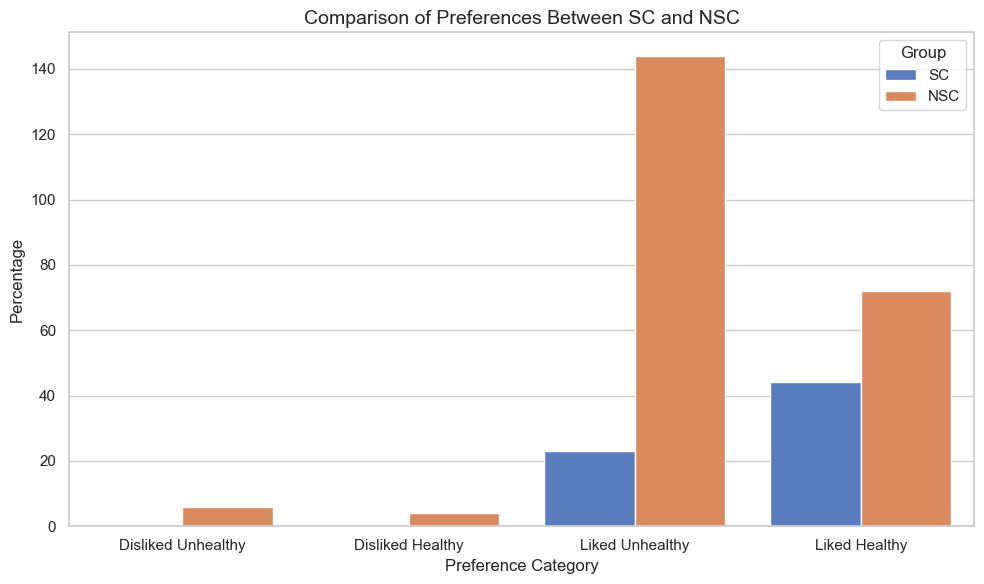

In [11]:
def count_disliked_unhealthy(df):
    df = clean_data(df)
    # find the number of diliked unhealthy items
    disliked_unhealthy = 0
    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            if (stim_rating["taste"] == "NaN" or stim_rating["health"] == "NaN" or row["coded_response"] == "NaN"):
                continue
            if int(row["coded_response"]) == 0:
                if int(stim_rating["taste"]) < 0:
                    if int(stim_rating["health"]) < 0:
                        disliked_unhealthy += 1
        else:
            continue
    return disliked_unhealthy

def count_disliked_healthy(df):
    df = clean_data(df)
    # find the number of diliked unhealthy items
    disliked_healthy = 0
    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            if (stim_rating["taste"] == "NaN" or stim_rating["health"] == "NaN" or row["coded_response"] == "NaN"):
                continue
            if int(row["coded_response"]) == 0:
                if int(stim_rating["taste"]) < 0:
                    if int(stim_rating["health"]) > 0:
                        disliked_healthy += 1
        else:
            continue
    return disliked_healthy

def count_liked_unhealthy(df):
    df = clean_data(df)
    # find the number of diliked unhealthy items
    liked_unhealthy = 0
    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            if (stim_rating["taste"] == "NaN" or stim_rating["health"] == "NaN" or row["coded_response"] == "NaN"):
                continue
            if int(row["coded_response"]) > 0:
                if int(stim_rating["taste"]) > 0:
                    if int(stim_rating["health"]) < 0:
                        liked_unhealthy += 1
        else:
            continue
    return liked_unhealthy

def count_liked_healthy(df):
    df = clean_data(df)
    # find the number of diliked unhealthy items
    liked_healthy = 0
    for index, row in df.iterrows():
        if row["exp_stage"] == "decision":
            stim_rating = eval(row["stim_rating"])
            if (stim_rating["taste"] == "NaN" or stim_rating["health"] == "NaN" or row["coded_response"] == "NaN"):
                continue
            if int(row["coded_response"]) > 0:
                if int(stim_rating["taste"]) > 0:
                    if int(stim_rating["health"]) > 0:
                        liked_healthy += 1
        else:
            continue
    return liked_healthy

disliked_unhealthy = {"SC":0, "NSC":0}
disliked_healthy = {"SC":0, "NSC":0}
liked_unhealthy = {"SC":0, "NSC":0}
liked_healthy = {"SC":0, "NSC":0}

for file in os.listdir(SC_DIR):
    df = pd.read_csv(os.path.join(SC_DIR, file))
    disliked_unhealthy["SC"] += count_disliked_unhealthy(df)
    disliked_healthy["SC"] += count_disliked_healthy(df)
    liked_unhealthy["SC"] += count_liked_unhealthy(df)
    liked_healthy["SC"] += count_liked_healthy(df)

for file in os.listdir(NSC_DIR):
    df = pd.read_csv(os.path.join(NSC_DIR, file))
    disliked_unhealthy["NSC"] += count_disliked_unhealthy(df)
    disliked_healthy["NSC"] += count_disliked_healthy(df)
    liked_unhealthy["NSC"] += count_liked_unhealthy(df)
    liked_healthy["NSC"] += count_liked_healthy(df)

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data for plotting
data = {
    "Category": [
        "Disliked Unhealthy", "Disliked Unhealthy",
        "Disliked Healthy", "Disliked Healthy",
        "Liked Unhealthy", "Liked Unhealthy",
        "Liked Healthy", "Liked Healthy"
    ],
    "Group": ["SC", "NSC", "SC", "NSC", "SC", "NSC", "SC", "NSC"],
    "Percentage": [
        disliked_unhealthy["SC"], disliked_unhealthy["NSC"],
        disliked_healthy["SC"], disliked_healthy["NSC"],
        liked_unhealthy["SC"], liked_unhealthy["NSC"],
        liked_healthy["SC"], liked_healthy["NSC"]
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create bar plot
sns.barplot(
    x="Category", y="Percentage", hue="Group", data=df, palette="muted"
)

# Add labels and title
plt.title("Comparison of Preferences Between SC and NSC", fontsize=14)
plt.xlabel("Preference Category", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(title="Group")

# Show plot
plt.tight_layout()
plt.show()

In [12]:
print(liked_healthy)

{'SC': 44, 'NSC': 72}
